In [15]:
# Standard library imports
import os
from datetime import datetime
from pathlib import Path
from typing import Annotated, Sequence, TypedDict

# Third-party imports
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [16]:
def load_all_txt_files(directory_path):
    """
    Load all .txt files from a directory into a single large string.
    
    Args:
        directory_path: Path to the directory containing .txt files
    
    Returns:
        A single string containing all text file contents
    """
    combined_string = ""
    
    # Get all .txt files from the directory
    txt_files = sorted(Path(directory_path).glob("*.txt"))
    
    # Read each file and append to the combined string
    for txt_file in txt_files:
        try:
            with open(txt_file, 'r', encoding='utf-8') as file:
                content = file.read()
                combined_string += content
                # Optional: Add separator between files
                # combined_string += "\n\n---\n\n"
        except Exception as e:
            print(f"Error reading {txt_file}: {e}")
    
    return combined_string

# Example usage
directory = "src/data/parsedMemories"  # Current directory, or specify your path
result = load_all_txt_files(directory)
print(f"Total characters loaded: {len(result)}")
print(f"First 100 characters: {result[:100]}")


Total characters loaded: 2349
First 100 characters: Image_UID: picture1
People: Tippi Hedren
Year: 
Event: 
Story: 
Image_UID: picture10
People: Melanie


In [17]:
def load_textfile_as_string(file_path):
    """
    Load a text file and return its contents as a string.
    
    Args:
        file_path: Path to the text file
    
    Returns:
        String containing the file contents
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

text = load_textfile_as_string("src/data/facts.txt")
print(text)

Tippi Hedren (Nathalie Kay Hedren) is 95 years old, born on January 19 1930 in New Ulm, Minnesota. They work as actress, model, animal rights activist. Their first favorite film was Gone with the Wind (1939), and their favorite starring role was "Marnie". Their favorite leading man is Sean Connery. They have a fear of spiders, and their favorite color is red.


In [18]:
from langchain_core.tools import tool

@tool
def write_to_daily_file(text, directory_path="./src/data/logs") -> str: 
    """
    Writes a string to a file named with today's date.
    
    Parameters:
    -----------
    text : str
        The text content to write to the file
    directory_path : str
        The directory path where the file should be created/stored (default is current directory)
    
    Returns:
    --------
    str
        The full path of the file that was written to
    """
    # Get today's date in YYYY-MM-DD format
    today = datetime.now().strftime("%Y-%m-%d")
    
    # Create the filename with today's date
    filename = f"{today}.txt"
    
    # Create the full file path
    file_path = os.path.join(directory_path, filename)
    
    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True)
    
    # Check if file exists to determine the mode
    file_exists = os.path.exists(file_path)
    
    # Write to the file (append mode to preserve existing content)
    with open(file_path, 'a') as f:
        f.write(text + "\n")
    
    # Return information about what was done
    action = "Appended to existing" if file_exists else "Created new"
    print(f"{action} file: {file_path}")
    
    return file_path


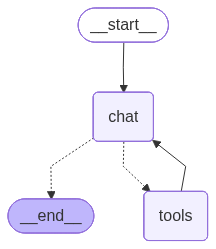

In [19]:
# Load environment variables
load_dotenv(".env")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# Your tool definition
@tool
def write_to_daily_file(text: str, directory_path: str = "./src/data/logs") -> str: 
    """
    Writes a string to a file named with today's date.
    
    Parameters:
    -----------
    text : str
        The text content to write to the file
    directory_path : str
        The directory path where the file should be created/stored
    
    Returns:
    --------
    str
        The full path of the file that was written to
    """
    today = datetime.now().strftime("%Y-%m-%d")
    filename = f"{today}.txt"
    file_path = os.path.join(directory_path, filename)
    os.makedirs(directory_path, exist_ok=True)
    file_exists = os.path.exists(file_path)
    
    with open(file_path, 'a') as f:
        f.write(text + "\n")
    
    action = "Appended to existing" if file_exists else "Created new"
    print(f"{action} file: {file_path}")
    
    return file_path

# Define the state
class ChatState(TypedDict):
    """The state of the chat."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Initialize Gemini model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    temperature=0.7,
    max_retries=2,
)

# Define your tools list
tools = [write_to_daily_file]

# Bind tools to the LLM - this tells the LLM what tools are available
llm_with_tools = llm.bind_tools(tools)

# System message
SYSTEM_MESSAGE = SystemMessage(
    content="You are a helpful assistant that answers concisely. Your user is " + 
    load_textfile_as_string("src/data/facts.txt") + 
    " Here is the additional memories about your user:" + 
    load_all_txt_files(directory)
)

def chat_node(state: ChatState):
    """Process messages with Gemini."""
    messages = [SYSTEM_MESSAGE] + list(state["messages"])
    # Use llm_with_tools instead of llm
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create the graph
workflow = StateGraph(ChatState)

# Add the chat node
workflow.add_node("chat", chat_node)

# Add the tool node - this executes the tools when called
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.set_entry_point("chat")

# Add conditional edges - routes to tools if LLM requests them, otherwise END
workflow.add_conditional_edges(
    "chat",
    tools_condition,  # Built-in function that checks for tool calls
)

# After tools execute, return to chat node
workflow.add_edge("tools", "chat")

# Compile the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [20]:

# Run the graph with user input and conversation history
if __name__ == "__main__":
    print("LangGraph Interactive Chat (with history)")
    print("Type 'exit' or 'quit' to end the conversation")
    print("-" * 50)
    
    conversation_history = []
    
    while True:
        # Get user input
        user_input = input("\nEnter your message: ").strip()
        
        # Check for exit commands
        if user_input.lower() in ['exit', 'quit', 'q']:
            print("Goodbye!")
            break
        
        # Skip empty inputs
        if not user_input:
            continue
        
        # Print user input
        print(f"\nYou: {user_input}")
        
        # Add user message to history
        conversation_history.append(HumanMessage(content=user_input))
        
        # Create inputs with full conversation history
        inputs = {"messages": conversation_history}
        
        # Stream the response
        print("\nAssistant: ", end="")
        for state in graph.stream(inputs, stream_mode="values"):
            last_message = state["messages"][-1]
            # Add assistant's response to history
            if last_message.type != "human" and last_message not in conversation_history:
                conversation_history.append(last_message)
                print(last_message.content, end="")
        print()  # New line after response


LangGraph Interactive Chat (with history)
Type 'exit' or 'quit' to end the conversation
--------------------------------------------------

You: hi can you write a log for the day saying banana bozo

Assistant: Appended to existing file: ./src/data/logs/2025-10-27.txt
./src/data/logs/2025-10-27.txtI have written "banana bozo" to a file named with today's date in the directory: ./src/data/logs/. The file path is ./src/data/logs/2025-10-27.txt
Goodbye!
